In [2]:
include("MySimplexQuad.jl")
using .MySimplexQuad

include("OrthoPols.jl")
using .OrthoPols

use_bigfloat = false

###############################################################

function rse(vec::Vector{T}) where T
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################


function Trans(point::Vector{T}) where T
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # (0,0) maps to this
    v2 = T[ 1, -1 / sqrt(T(3))]   # (1,0) maps to this
    v3 = T[ 0,  2 / sqrt(T(3))]   # (0,1) maps to this
    
    # Extract x and y from the input point
    x, y = point

    # Compute the affine transformation
    new_x = (v2[1] - v1[1]) * x + (v3[1] - v1[1]) * y + v1[1]
    new_y = (v2[2] - v1[2]) * x + (v3[2] - v1[2]) * y + v1[2]

    return T[new_x, new_y]
end

function TransJ()
    # Determine the type based on the global variable
    T = use_bigfloat ? BigFloat : Float64

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]
    v2 = T[ 1, -1 / sqrt(T(3))]
    v3 = T[ 0,  2 / sqrt(T(3))]
    
    # Compute the Jacobian matrix
    J = T[
        v2[1] - v1[1]  v3[1] - v1[1];
        v2[2] - v1[2]  v3[2] - v1[2]
    ]
    
    return J
end

function TransBack(point::Vector{T}) where T
    @assert length(point) == 2 "Input point must be a 2-element vector"

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # Maps to (0,0)
    v2 = T[ 1, -1 / sqrt(T(3))]   # Maps to (1,0)
    v3 = T[ 0,  2 / sqrt(T(3))]   # Maps to (0,1)
    
    # Extract x and y from the input point
    x, y = point

    # Compute the inverse affine transformation
    denominator = (v1[1] * (v2[2] - v3[2]) + v2[1] * (v3[2] - v1[2]) + v3[1] * (v1[2] - v2[2]))
    
    new_x = ((v2[2] - v3[2]) * (x - v1[1]) + (v3[1] - v2[1]) * (y - v1[2])) / denominator
    new_y = ((v3[2] - v1[2]) * (x - v2[1]) + (v1[1] - v3[1]) * (y - v2[2])) / denominator

    return T[new_x, new_y]
end

function TransBackJ()
    # Determine the type based on the global variable
    T = use_bigfloat ? BigFloat : Float64

    # Define the vertices of the target triangle
    v1 = T[-1, -1 / sqrt(T(3))]   # Maps to (0,0)
    v2 = T[ 1, -1 / sqrt(T(3))]   # Maps to (1,0)
    v3 = T[ 0,  2 / sqrt(T(3))]   # Maps to (0,1)
    
    # Compute the denominator
    denominator = (v1[1] * (v2[2] - v3[2]) + v2[1] * (v3[2] - v1[2]) + v3[1] * (v1[2] - v2[2]))
    
    # Compute the Jacobian matrix
    J = T[(v2[2] - v3[2]) / denominator  (v3[1] - v2[1]) / denominator;
          (v3[2] - v1[2]) / denominator  (v1[1] - v3[1]) / denominator]
    
    return J
end

###############################################################

TransBackJ (generic function with 1 method)

In [3]:
using LinearAlgebra
using Optim
using Plots
using Optim
using LineSearches


freeparam = 3
order = 6
# indices = [1,4,6,8,10,11,13,15]
indices = 1:(Int((order+1)*(order+2)/2))

###############################################################

function (vec::Vector{T}) where T <: AbstractFloat
    threshold = if T == BigFloat
        BigFloat("1e-60")
    else
        T(1e-14)
    end
    
    map(x -> abs(x) < threshold ? zero(T) : x, vec)
end

###############################################################
p1 = use_bigfloat ? BigFloat[0.0, 0.0] : [0.0, 0.0]
p2 = use_bigfloat ? BigFloat[1.0, 0.0] : [1.0, 0.0]
p3 = use_bigfloat ? BigFloat[0.0, 1.0] : [0.0, 1.0]

m1 = (p2 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m2 = (p1 .+ p3) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)
m3 = (p1 .+ p2) ./ (use_bigfloat ? BigFloat(2.0) : 2.0)

b = (p1 .+ p2 .+ p3) ./ (use_bigfloat ? BigFloat(3.0) : 3.0)
###############################################################


# vertices
T1 = hcat(p1, p2, p3)
eval_T1(order) = (ortho2eva3(order, Trans(T1[:,1]))[1])+
                 (ortho2eva3(order, Trans(T1[:,2]))[1])+
                 (ortho2eva3(order, Trans(T1[:,3]))[1])

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(order) = (ortho2eva3(order, Trans(T2[:,1]))[1])+
                 (ortho2eva3(order, Trans(T2[:,2]))[1])+
                 (ortho2eva3(order, Trans(T2[:,3]))[1])

# midpoint
T3 = hcat(b)
eval_T3(order) = (ortho2eva3(order, Trans(T3[:,1]))[1])


# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

dT4 = hcat(p1.-p2,
           p2.-p1,
           p3.-p1,
           p1.-p3,
           p3.-p2,
           p2.-p3)

eval_T4(order,a) = (ortho2eva3(order, Trans(T4(a)[:,1]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,2]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,3]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,4]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,5]))[1])+
                   (ortho2eva3(order, Trans(T4(a)[:,6]))[1])

eval_dT4(order,a) = ([ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1])+
                     [ortho2eva3(order, Trans(T4(a)[:,1]))[2], ortho2eva3(order, Trans(T4(a)[:,1]))[3]]'*TransJ()*(dT4[:,1]))'

# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1,
             a * m2 .+ (1 .- a) * p2,
             a * m3 .+ (1 .- a) * p3)

dT5 = hcat(m1-p1,
           m2-p2,
           m3-p3)

eval_T5(order,a) = ortho2eva3(order, Trans(T5(a)[:,1]))[1]+
                   ortho2eva3(order, Trans(T5(a)[:,2]))[1]+
                   ortho2eva3(order, Trans(T5(a)[:,3]))[1]

eval_dT5(order,a) = ([ortho2eva3(order, Trans(T5(a)[:,1]))[2], ortho2eva3(order, Trans(T5(a)[:,1]))[3]]'*TransJ()*(dT5[:,1])+
                     [ortho2eva3(order, Trans(T5(a)[:,2]))[2], ortho2eva3(order, Trans(T5(a)[:,2]))[3]]'*TransJ()*(dT5[:,2])+
                     [ortho2eva3(order, Trans(T5(a)[:,3]))[2], ortho2eva3(order, Trans(T5(a)[:,3]))[3]]'*TransJ()*(dT5[:,3]))'


# inner class, type 2
T6(a, b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                 b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

daT6(b) = hcat(b * (m1 - p1) + (1 - b) * (m2 - p2),
               b * (m1 - p1) + (1 - b) * (m3 - p3),
               b * (m3 - p3) + (1 - b) * (m2 - p2),
               b * (m2 - p2) + (1 - b) * (m1 - p1),
               b * (m3 - p3) + (1 - b) * (m1 - p1),
               b * (m2 - p2) + (1 - b) * (m3 - p3))

dbT6(a) = hcat((a * m1 + (1 - a) * p1) - (a * m2 + (1 - a) * p2),
               (a * m1 + (1 - a) * p1) - (a * m3 + (1 - a) * p3),
               (a * m3 + (1 - a) * p3) - (a * m2 + (1 - a) * p2),
               (a * m2 + (1 - a) * p2) - (a * m1 + (1 - a) * p1),
               (a * m3 + (1 - a) * p3) - (a * m1 + (1 - a) * p1),
               (a * m2 + (1 - a) * p2) - (a * m3 + (1 - a) * p3))

eval_T6(order,a,b) = ortho2eva3(order, Trans(T6(a, b)[:,1]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,2]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,3]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,4]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,5]))[1]+
                     ortho2eva3(order, Trans(T6(a, b)[:,6]))[1]

eval_daT6(order,a,b) = ([ortho2eva3(order, Trans(T6(a, b)[:,1]))[2], ortho2eva3(order, Trans(T6(a, b)[:,1]))[3]]'*TransJ()*(daT6(b)[:,1])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,2]))[2], ortho2eva3(order, Trans(T6(a, b)[:,2]))[3]]'*TransJ()*(daT6(b)[:,2])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,3]))[2], ortho2eva3(order, Trans(T6(a, b)[:,3]))[3]]'*TransJ()*(daT6(b)[:,3])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,4]))[2], ortho2eva3(order, Trans(T6(a, b)[:,4]))[3]]'*TransJ()*(daT6(b)[:,4])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,5]))[2], ortho2eva3(order, Trans(T6(a, b)[:,5]))[3]]'*TransJ()*(daT6(b)[:,5])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,6]))[2], ortho2eva3(order, Trans(T6(a, b)[:,6]))[3]]'*TransJ()*(daT6(b)[:,6]))'

eval_dbT6(order,a,b) = ([ortho2eva3(order, Trans(T6(a, b)[:,1]))[2], ortho2eva3(order, Trans(T6(a, b)[:,1]))[3]]'*TransJ()*(dbT6(a)[:,1])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,2]))[2], ortho2eva3(order, Trans(T6(a, b)[:,2]))[3]]'*TransJ()*(dbT6(a)[:,2])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,3]))[2], ortho2eva3(order, Trans(T6(a, b)[:,3]))[3]]'*TransJ()*(dbT6(a)[:,3])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,4]))[2], ortho2eva3(order, Trans(T6(a, b)[:,4]))[3]]'*TransJ()*(dbT6(a)[:,4])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,5]))[2], ortho2eva3(order, Trans(T6(a, b)[:,5]))[3]]'*TransJ()*(dbT6(a)[:,5])+
                        [ortho2eva3(order, Trans(T6(a, b)[:,6]))[2], ortho2eva3(order, Trans(T6(a, b)[:,6]))[3]]'*TransJ()*(dbT6(a)[:,6]))'

# System setup
function A(a)
    hcat(
        eval_T1(order)[indices], # trig vertices
        # eval_T2(order)[indices], # edge midpoints

        eval_T4(order,a[1])[indices], # edge class
        # eval_T4(order,a[2])[indices], # edge class
        
        eval_T5(order,a[2])[indices], # inner class, type 1
        eval_T5(order,a[3])[indices], # inner class, type 1
        # eval_T5(order,a[5])[indices], # inner class, type 1
        
        # eval_T3(order)[indices], # trig midpoint
        
        # eval_T6(order,a[6],a[7])[indices],
        # eval_T5(order,a[8])[indices],
    )
end

function dA1(a)
    hcat(
        0*eval_T1(order)[indices],
        # 0*eval_T2(order)[indices],
        eval_dT4(order,a[1])[indices],
        0*eval_dT5(order,a[2])[indices],
        0*eval_dT5(order,a[3])[indices],
    )
end
function dA2(a)
    hcat(
        0*eval_T1(order)[indices],
        # 0*eval_T2(order)[indices],
        0*eval_dT4(order,a[1])[indices],
        eval_dT5(order,a[2])[indices],
        0*eval_dT5(order,a[3])[indices],
    )
end
function dA3(a)
    hcat(
        0*eval_T1(order)[indices],
        # 0*eval_T2(order)[indices],
        0*eval_dT4(order,a[1])[indices],
        0*eval_dT5(order,a[2])[indices],
        eval_dT5(order,a[3])[indices],
    )
end

function rhs()
    T = use_bigfloat ? BigFloat : Float64
    X, W = mysimplexquad(T, order, 2)
    w = zeros(T, div((order + 1) * (order + 2), 2))[indices]  # Initialize w with the correct type and size
    
    for k = 1:length(W)
        pols = (ortho2eva3(order, Trans(T.(X[k,:])))[1])[indices]
        w .+= 2*W[k] .* pols
    end
    return w
end

f(a) = norm(A(a)*((A(a)' * A(a))\(A(a)' * rhs()))-rhs())
g(a) = A(a)*((A(a)' * A(a))\(A(a)' * rhs()))-rhs()

g (generic function with 1 method)

In [40]:
# a = 0.134
# dq = 0.0000001
# display((A(a.+dq)-A(a.-dq))/(2*dq))

# display(dA(a))

# dA(0.2)

# K(a) = ortho2eva3(order, Trans(T5(a)[:,1]))[1]
# dK(a) = ([ortho2eva3(order, Trans(T5(a)[:,1]))[2], 
#           ortho2eva3(order, Trans(T5(a)[:,1]))[3]]'*TransJ()*(dT5[:,1]))'

# display((K(a.+dq)-K(a.-dq))/(2*dq))
# display(dK(a))

# up(0.38)



In [41]:
A([0.2,0.25,0.3])
# TransJ()

28×4 Matrix{Float64}:
  2.27951       4.55901       2.27951       2.27951
 -1.54088e-17   4.44089e-16   0.0          -2.89112e-16
  0.0           1.11022e-15   6.66134e-16   0.0
  5.88566       4.23768       1.10356       0.411996
  1.45639e-15   1.55431e-15   0.0           6.41051e-16
  6.58037       4.73787       1.23382       0.460626
 -3.55271e-15   1.38778e-16   0.0          -1.37746e-15
 -6.79618       2.71847      -0.623868     -0.564932
  2.03409e-15   2.66454e-15   0.0           7.99936e-16
  3.03934      -1.21574       0.279002      0.252645
  ⋮                                        
  1.16385e-14   2.22045e-15   0.0           7.34973e-17
  7.44484      -6.78969       0.614117      1.00576
 14.4967        6.29599      -1.11735       0.236662
  1.42109e-14   1.31839e-16   0.0           1.51159e-15
 12.062        -7.66874       2.44375       2.68866
  4.44089e-15   1.33227e-14   0.0          -2.21846e-15
  8.9905       10.2017       -2.33875      -1.06887
  2.25367e-14  -1.110

In [42]:
# a = 0.2#4/(7 + sqrt(BigFloat("13")))

a = [0.1,0.31,0.3]


B(a) = A(a)'*A(a)
C(a) = inv(B(a))

# The last term in J(a) is always zero, since dA(a)'*rhs() is zero!
# J(a) = dA(a)*C(a)*A(a)'*rhs() -A(a)*C(a)*(dA(a)'*A(a)+A(a)'*dA(a))*C(a)*A(a)'*rhs() +A(a)*C(a)*dA(a)'*rhs()


dAA1(a) = vcat(dA1(a),dA2(a),dA3(a))
J1(a) = reshape(dAA1(a)*C(a)*A(a)'*rhs(),:,3)


m(a) = vcat(dA1(a)'*A(a)+A(a)'*dA1(a),
            dA2(a)'*A(a)+A(a)'*dA2(a),
            dA3(a)'*A(a)+A(a)'*dA3(a))

J2(a) = -A(a)*C(a)*reshape(m(a)*C(a)*A(a)'*rhs(),:,3)

J(a) = J1(a) + J2(a)


up(a) = inv(J(a)'*J(a))*J(a)'

cond(J(a)'*J(a))

# g(a)

31362.77935197747

In [43]:
C([0.2,0.3,0.4])

4×4 Matrix{Float64}:
  0.000997393   0.000110769   0.00455984  -0.00775353
  0.000110769   0.00233966    0.00511178  -0.00332904
  0.00455984    0.00511178    0.120598    -0.132859
 -0.00775353   -0.00332904   -0.132859     0.200724

In [56]:
# a = [0.3077456934940429656111, 0.237227334916236420,  0.85068024455122430]
# a = BigFloat.["0.6894807431364100579396918181180814433517535177968706938351552098259565706780567", "0.8507006310889774391442044803876179324818943043445105747053922691075143478651292", "0.2368362067571452850895786255825590085510715845462959305260082230192311735189575"]
using Printf

for k=1:100
    min_val = 0.2
    max_val = 0.6
    a = min_val .+ (max_val - min_val) .*(rand(freeparam))
    bad = false

    print("starting with a new config: ")
    print("f(a) is about $(@sprintf("%.3g", f(a))). ")
    for i=1:100
        try
            res = up(a)*g(a)
            a = a-res

            # println("$(@sprintf("%.3g", f(a))). ", norm(res))
            if norm(res)<1e-20
                print(".. res looking good!.")
                bad = false
                break
            end

            # println(a)
            
            if all(x -> (x<0), a)
                bad = true
                print(".. neg weights.\n")
                break
            elseif norm(res)>5
                print(".. res norm too big, breaking.\n")
                bad = true
                break
            elseif any(x-> (x>10), a)
                print(".. big weights.\n")
                bad = true
                break
            end
        catch e
            bad = true
            print(".. nans... breaking\n")
            break
        end
    end

    if !bad
        print(".. found something promising...")
        weights = ((A(a)' * A(a))\(A(a)' * rhs()))
        

        if all(x -> (x>0), weights)
            print(" WEIGHTS POSITIVE! \n")
            break
        else
            print("..weights negative, continuing \n")
        end
    end
end

starting with a new config: f(a) is about 0.59. .. found something promising.....weights negative, continuing 
starting with a new config: f(a) is about 0.676. .. res norm too big, breaking.
starting with a new config: f(a) is about 0.591. .. found something promising.....weights negative, continuing 
starting with a new config: f(a) is about 0.588. .. res norm too big, breaking.
starting with a new config: f(a) is about 0.609. .. res norm too big, breaking.
starting with a new config: f(a) is about 0.588. .. found something promising.....weights negative, continuing 
starting with a new config: f(a) is about 0.574. .. found something promising.....weights negative, continuing 
starting with a new config: f(a) is about 0.656. .. found something promising.....weights negative, continuing 
starting with a new config: f(a) is about 0.586. .. res norm too big, breaking.
starting with a new config: f(a) is about 0.642. .. found something promising.....weights negative, continuing 
starting 

In [45]:
# a = BigFloat.([ "0.3077459416259916461046161526591041048806757743771913510581592529605354815399686", 
#                 "0.2372273727931857363813267749218775171797307013464556548442118385620957007545132",  
#                 "0.8506802519794943040508623040490795223900636224346451182274523320435129439771795"])
# for i=1:100
#     a = a -up(a)*g(a)
#     res = norm(up(a)*g(a))
#     println(res)
#     if res<1e-30
#         break
#     end
# end

# print(a)

In [57]:
weights = ((A(a)' * A(a))\(A(a)' * rhs()))
display(a)
display(weights)
display(f(a))

3-element Vector{Float64}:
 0.6922540583740082
 0.8506802519794945
 0.23722737279318606

4-element Vector{Float64}:
 0.00713035930720438
 0.0295694161768052
 0.16517948864556656
 0.10188465302695215

4.971800425196354e-15

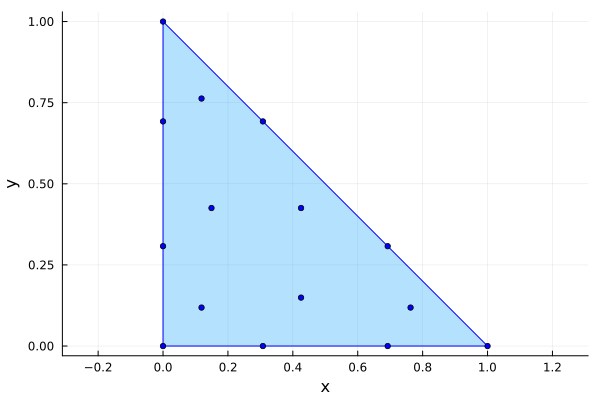

In [54]:
using Plots
# gr()  # Set the backend to GR
plot()
# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]


# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T2[1, :], T2[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T3[1, :], T3[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T4(a[2])[1, :], T4(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T5(a[2])[1, :], T5(a[2])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[3])[1, :], T5(a[3])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)
# scatter!(T5(a[5])[1, :], T5(a[5])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T6(a[6],a[7])[1, :], T6(a[6],a[7])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# scatter!(T5(a[8])[1, :], T5(a[8])[2, :], markersize = 3, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")

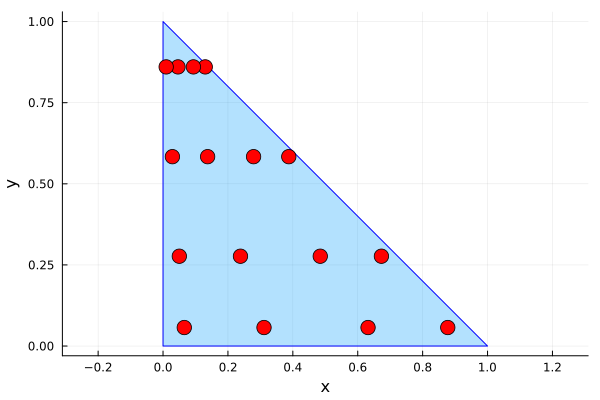

In [49]:
vertices = [
    0.0 0.0
    1.0 0.0
    0.0 1.0
]

# Need at least 4 vertices for plotting?
vertices1 = [vertices; vertices[1:1, :]]

using Plots
plot()

# for npoints in [1,2]
npoints = 4
    X, W = mysimplexquad(BigFloat, npoints, 2)

    # Plot the triangle
    plot!(vertices1'[1,:], vertices1'[2,:], seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)
    scatter!(X[:, 1], X[:, 2], markersize = 8, markercolor = :red, legend = false, aspect_ratio = :equal)

    # Add plot title and labels
    xlabel!("x")
    ylabel!("y")
# end

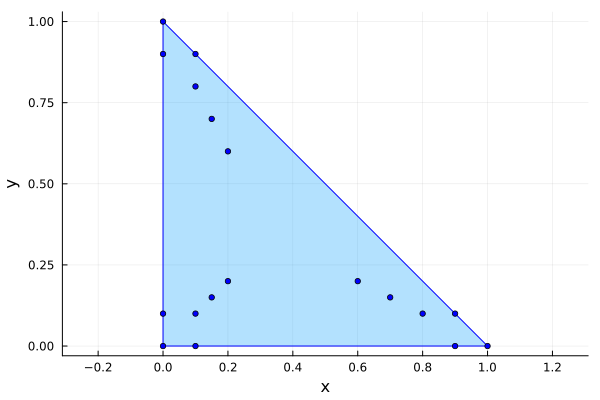

In [6]:
function plot_configuration(specs, a)
    # Create a new plot
    p = plot()

    # Define the vertices of the triangle
    p1, p2, p3 = [0,0], [0,1], [1,0]
    x = [p1[1], p2[1], p3[1], p1[1]]
    y = [p1[2], p2[2], p3[2], p1[2]]

    # Plot the triangle
    plot!(p, x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

    a_index = 1
    for (T, param_count) in specs
        if T == 1
            scatter!(p, T1[1, :], T1[2, :], markersize = 3, markercolor = :blue)
        elseif T == 2
            scatter!(p, T2[1, :], T2[2, :], markersize = 3, markercolor = :blue)
        elseif T == 3
            scatter!(p, T3[1, :], T3[2, :], markersize = 3, markercolor = :blue)
        elseif T == 4
            for i in 1:param_count
                scatter!(p, T4(a[a_index])[1, :], T4(a[a_index])[2, :], markersize = 3, markercolor = :blue)
                a_index += 1
            end
        elseif T == 5
            for i in 1:param_count
                scatter!(p, T5(a[a_index])[1, :], T5(a[a_index])[2, :], markersize = 3, markercolor = :blue)
                a_index += 1
            end
        elseif T == 6
            scatter!(p, T6(a[a_index], a[a_index+1])[1, :], T6(a[a_index], a[a_index+1])[2, :], markersize = 3, markercolor = :blue)
            a_index += 2
        end
    end

    # Add plot title and labels
    xlabel!(p, "x")
    ylabel!(p, "y")

    return p  # Return the plot object
end

# Usage
specs = [(1, 0), 
         (4, 1), 
         (5, 1), 
         (5, 2)]

a = [0.1, 0.2, 0.3, 0.4]

p = plot_configuration(specs, a)
display(p)